In [1]:
from preprocessing.processing import EEGPreprocessor 
from preprocessing.windowing import EEGWindower
from preprocessing.frame_selector import EEGFrameSelector 
from preprocessing.frame_exporter2 import EEGFrameExporter
from preprocessing.constants import ( 
    BASE_DIR, BASE_CSV_PATH, EDF_DIR,
    DEFAULT_NOTCH_FREQ, DEFAULT_NOTCH_Q,
    DEFAULT_HP_CUTOFF, DEFAULT_LP_CUTOFF, 
    AVERAGE_MONTAGE, AVERAGE_CH_TO_REMOVE,
    CZ_MONTAGE, CZ_CH_TO_REMOVE,
    FZ_MONTAGE, FZ_CH_TO_REMOVE,
    DEFAULT_SFREQ, DEFAULT_PERCENTILE,
)  

In [2]:
import pandas as pd
import numpy as np

In [3]:
BASE_DIR, EDF_DIR, BASE_CSV_PATH 

('/dmj/fizmed/mmarzec/licencjat_neuro',
 '/dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_edfs',
 '/dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_info.csv')

WYBÓR NAGRANIA EEG ZE SZPITALA SZC

In [4]:
data = pd.read_csv(BASE_CSV_PATH) 
data_szc = data[data['institution_id'] == 'SZC']

In [5]:
data_szc

,examination_id,patient_original_id,age_dec,patient_sex,institution_id,classification
4,20220512-152511-{61074308-a109-40b1-97cb-43dcb...,{238385d0-7169-42a6-b94f-6ddbc4e08746},60.583333,Male,SZC,patho
5,20220512-151748-{5d0347f5-6902-47e3-aad0-8355e...,{2f50797c-774a-4611-814b-f6f8e3202111},62.916667,Female,SZC,patho
6,20220512-155641-{810f6d80-23e2-41ef-b68c-dee45...,{6d3f7d71-c7b6-448c-944e-21546debbfe2},54.750000,Female,SZC,patho
9,20220512-153216-{bfa23f5b-5051-431c-a77f-dff01...,{bb2ce00d-0036-4696-a80c-a99ffc5663fb},30.166667,Female,SZC,patho
13,20220512-165737-{d5acb6d0-b682-42c1-9362-001a9...,{575c950a-c4ed-496b-9abb-31f4921dc152},16.833333,Male,SZC,norm
...,...,...,...,...,...,...
42517,20220512-151645-{433cd26e-fdcc-4df2-8262-6a585...,{1b986dca-28d8-40a4-8917-8a807b93f25f},41.250000,Female,SZC,norm
42518,20220512-160942-{80e473d0-76db-4688-bc62-35fe8...,{1b986dca-28d8-40a4-8917-8a807b93f25f},39.833333,Female,SZC,norm
42519,20220512-161121-{c5e5998f-63cb-4eba-a413-bb964...,{1b986dca-28d8-40a4-8917-8a807b93f25f},42.333333,Female,SZC,norm
42520,20220512-150750-{a4b3c83e-a4d6-4c2d-b036-4c420...,{ebb5d06c-a651-40d8-b22a-e126c3f82295},36.666667,Male,SZC,norm


In [6]:
label = data_szc['classification'].iloc[551]

In [7]:
edf_path = f"{EDF_DIR}/{data_szc['examination_id'].iloc[551]}.edf" # type:ignore
institution_id_szc = data_szc['institution_id'].iloc[551]

In [8]:
institution_id_szc, label

('SZC', 'norm')

In [9]:
CHOICE_OF_FRAME_LEN = 6
counter = 0

PREPROCESSING

In [10]:
preprocessor = EEGPreprocessor.from_edf(
    edf_path=edf_path,
    institution_id=institution_id_szc,
    preload=True
)

print("BEFORE PREPROCESSING")
print(f"  {len(preprocessor.raw.ch_names)} channels")
print(f"  Fs [Hz] : {preprocessor.raw.info['sfreq']} Hz")
print(f"  Length [s]: {preprocessor.raw.times[-1]:.1f} s")
print(f"  Ch_names : {preprocessor.raw.ch_names}")

Extracting EDF parameters from /dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_edfs/20220512-155621-{6183e5bc-9603-4bbd-858e-4e3ee2be99ca}.edf...
Setting channel info structure...
Creating raw.info structure...


Reading 0 ... 182999  =      0.000 ...   731.996 secs...
BEFORE PREPROCESSING
  19 channels
  Fs [Hz] : 250.0 Hz
  Length [s]: 732.0 s
  Ch_names : ['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG Fz', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG Cz', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG Pz', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2']


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[Filter Info] HP Order: 3
[Filter Info] LP Order: 5
[Drop Channel] Removed: Cz
Using matplotlib as 2D backend.


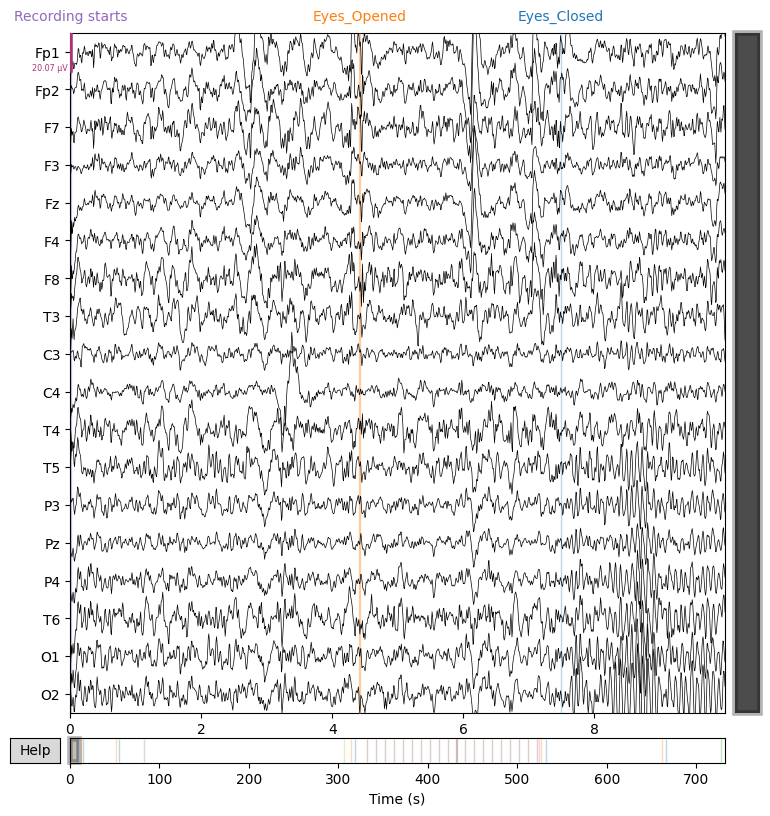

AFTER PREPROCESSING
 Standarized ch_names: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
 Resampled Fs: 128.0 Hz


In [11]:
raw_preprocessed = preprocessor.preprocess(
    ref_channels=CZ_MONTAGE,                    # Referencja: average, 'Cz', 'Fz' lub lista kanałów 
    ch_to_drop = CZ_CH_TO_REMOVE,
    sfreq=DEFAULT_SFREQ,                        # Resample do 128 Hz
    notch_freq= DEFAULT_NOTCH_FREQ,             # Notch filter: 50 Hz (Europa) lub 60 Hz (USA)
    hp_cutoff= DEFAULT_HP_CUTOFF,               # High-pass: 0.5 Hz (usuwa dryft)
    lp_cutoff= DEFAULT_LP_CUTOFF,               # Low-pass: 45 Hz
    plot=True,                                  # Ustaw True aby zobaczyć sygnał
    percentile=DEFAULT_PERCENTILE               # Percentyl dla skalowania wykresu
)

print("AFTER PREPROCESSING")
print(f" Standarized ch_names: {raw_preprocessed.ch_names}")
print(f" Resampled Fs: {raw_preprocessed.info['sfreq']} Hz")

WINDOWING -- SEGEMENTACJA NA RAMKI

In [13]:
windower = EEGWindower(raw_preprocessed)

Detected units: V
Typical amplitude: 2.45e-06 V


In [14]:
clean_frames, info = windower.process_fixed_frames(
    frame_duration= CHOICE_OF_FRAME_LEN,  # n-sekundowe ramki
    drop_last_incomplete=True,            # Usuń ostatnią niepełną ramkę
    min_amplitude=1.0,                    # < 1 µV = płaska (elektroda odłączona)
    max_amplitude=600.0,                  # > 600 µV = artefakt (ruch, mięśnie)
    min_flat_channels=10,                 # Min. kanałów płaskich do odrzucenia
    min_bad_channels=1,                   # Min. kanałów z artefaktem do odrzucenia
    verbose=True
)

print(f"\n✓ Segmentacja zakończona!")
print(f"  Shape ramek: {clean_frames.shape}")
print(f"  (n_frames, n_channels, n_samples_per_frame)")

Segmentation Info:
  Recording duration: 732.0s
  Frame duration: 6s (768 samples @ 128.0Hz)
  Total frames: 122

Frame Rejection Summary:
  Data units: V
  Thresholds: 1.0 µV = 1.00e-06 V, 600.0 µV = 6.00e-04 V
  Total frames: 122
  Rejected: 0 (0.0%)
    - Flat (< 1.0 µV): 0
    - High amplitude (> 600.0 µV): 0
  Clean frames: 122

✓ Segmentacja zakończona!
  Shape ramek: (122, 18, 768)
  (n_frames, n_channels, n_samples_per_frame)


FRAME SELECTOR

In [15]:
selector = EEGFrameSelector.from_windower_results(
    raw=raw_preprocessed,
    windower=windower,
    process_info=info
)

print(f"✓ Selector zainicjalizowany")
print(f"  Clean frames: {len(selector.clean_frames)}")
print(f"  Shape: {selector.clean_frames.shape}")

✓ Selector zainicjalizowany
  Clean frames: 122
  Shape: (122, 18, 768)


In [16]:
annotation_counts = selector.list_annotations(verbose=True)

AVAILABLE ANNOTATIONS
  1. Recording starts (n=1, point marker)
  2. Eyes_Opened (n=6, point marker)
  3. Eyes_Closed (n=6, point marker)
  4. Stimulation_PhotostimulationStart (n=1, point marker)
  5. Stimulation_PhotostimulationStop (n=1, point marker)
  6. Stimulation_HyperventilationStart (n=20, point marker)
  7. Stimulation_HyperventilationStop (n=1, point marker)
  8. Recording ends (n=1, point marker)


FRAME GROUPING AND EXPORTING

In [17]:
exporter = EEGFrameExporter(
    selector=selector,
    output_dir=f"results/demoDTF/{counter}")#, exclude_events=['Recording starts', 'Recording ends'])

In [18]:
event_groups = exporter.get_valid_events(verbose=True)

AttributeError: 'EEGFrameExporter' object has no attribute 'get_valid_events'

In [ ]:
groups = selector.create_groups(
    event_groups=event_groups,
    match_mode='contains',
    store=True,
    verbose=True
)


SPLITTING FRAMES BY EVENTS

Group: eyes_opened
----------------------------------------
Event-based Frame Selection:
  Searched events: [np.str_('Eyes_Opened')]
  Match mode: contains
  Events found: 6
  Point markers (duration=0): 6/6
  Total clean frames: 122
  Frames with events: 6 (4.9%)

  Event details:
    1. Eyes_Opened: 4.4s (point marker)
    2. Eyes_Opened: 12.0s (point marker)
    3. Eyes_Opened: 51.7s (point marker)
    4. Eyes_Opened: 314.5s (point marker)
    5. Eyes_Opened: 526.6s (point marker)
    ... and 1 more events

Group: eyes_closed
----------------------------------------
Event-based Frame Selection:
  Searched events: [np.str_('Eyes_Closed')]
  Match mode: contains
  Events found: 6
  Point markers (duration=0): 6/6
  Total clean frames: 122
  Frames with events: 6 (4.9%)

  Event details:
    1. Eyes_Closed: 7.5s (point marker)
    2. Eyes_Closed: 14.7s (point marker)
    3. Eyes_Closed: 55.0s (point marker)
    4. Eyes_Closed: 318.2s (point marker)
    5. E

In [ ]:
saved_files = exporter.save_frames(
    groups=groups,
    source_file=edf_path,
    compress=True,
    verbose=True
)


SAVING FRAMES

Group: eyes_opened
  Frames: 6, Shape: (6, 19, 768)
  ✓ Saved: eyes_opened_frames_20251213_141633.npz (622.3 KB)

Group: eyes_closed
  Frames: 6, Shape: (6, 19, 768)
  ✓ Saved: eyes_closed_frames_20251213_141633.npz (622.7 KB)

Group: stimulation_photostimulationstart
  Frames: 1, Shape: (1, 19, 768)
  ✓ Saved: stimulation_photostimulationstart_frames_20251213_141633.npz (105.9 KB)

Group: stimulation_photostimulationstop
  Frames: 1, Shape: (1, 19, 768)
  ✓ Saved: stimulation_photostimulationstop_frames_20251213_141633.npz (106.0 KB)

Group: stimulation_hyperventilationstart
  Frames: 20, Shape: (20, 19, 768)
  ✓ Saved: stimulation_hyperventilationstart_frames_20251213_141633.npz (2069.2 KB)

Group: stimulation_hyperventilationstop
  Frames: 1, Shape: (1, 19, 768)
  ✓ Saved: stimulation_hyperventilationstop_frames_20251213_141633.npz (105.9 KB)

✓ Saved 6 groups to results/demoDTF/2/frames


In [ ]:
plot_files = exporter.visualize_all_groups(
    groups=groups,
    dpi=150,
    show=False,
    verbose=True
)


GENERATING VISUALIZATIONS

Group: eyes_opened
  ✓ Trace: eyes_opened_example_trace.png
  ✓ Overview: eyes_opened_overview.png
  ✓ Timeline: eyes_opened_timeline.png

Group: eyes_closed
  ✓ Trace: eyes_closed_example_trace.png
  ✓ Overview: eyes_closed_overview.png
  ✓ Timeline: eyes_closed_timeline.png

Group: stimulation_photostimulationstart
  ✓ Trace: stimulation_photostimulationstart_example_trace.png
  ✓ Overview: stimulation_photostimulationstart_overview.png
  ✓ Timeline: stimulation_photostimulationstart_timeline.png

Group: stimulation_photostimulationstop
  ✓ Trace: stimulation_photostimulationstop_example_trace.png
  ✓ Overview: stimulation_photostimulationstop_overview.png
  ✓ Timeline: stimulation_photostimulationstop_timeline.png

Group: stimulation_hyperventilationstart
  ✓ Trace: stimulation_hyperventilationstart_example_trace.png
  ✓ Overview: stimulation_hyperventilationstart_overview.png
  ✓ Timeline: stimulation_hyperventilationstart_timeline.png

Group: stimulatio